<a href="https://colab.research.google.com/github/hardikroutray/ECG/blob/main/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries or install unavailable libraries**

In [25]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
from imutils import paths
import time   # time1 = time.time(); print('Time taken: {:.1f} sec'.format(time.time() - time1))
import cv2
import pickle
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [80]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

In [12]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/MyDrive', force_remount=True)
!ls /content/MyDrive/MyDrive/ECG/data/

ECGImagesofMyocardialInfarctionPatients
ECGImagesofPatientthathaveabnormalheartbeat
ECGImagesofPatientthathaveHistoryofMI
NormalPersonECGImages


# **Study and process images for input into NN**

1.   A 12-lead based ECG image standard in hospitals
2.   A single image need to be cropped (better option ?) into 12 images. As a first pass, the entire image is used for classification
3. Each image is converted to a np array


In [33]:
# img = cv2.imread("/content/MyDrive/MyDrive/ECG/data/NormalPersonECGImages/Normal_1.jpg")
# print(img.shape)
# print(img[0][0])
# print(img[1000][1000])
# print(img[1571][2212])
# x_list, y_list = [], []

# for x in np.arange(0, 2213, 1):
#     for y in np.arange(0, 1572, 1):
#         if np.all(image[y][x] == (0, 0, 0)):   # black
#             x_list.append(x)
#             y_list.append(1572-y)
# show_graph(x_list, y_list, 20, 15)

(1572, 2213, 3)

<class 'PIL.Image.Image'>
None
L
(2213, 1572)


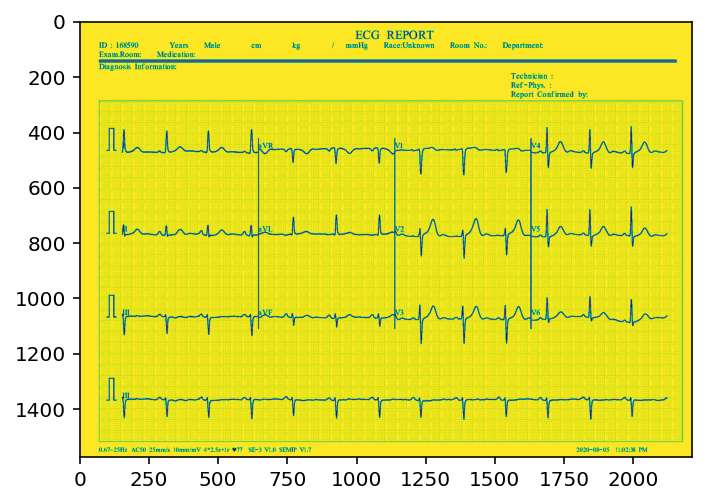

In [56]:
img = image.load_img('/content/MyDrive/MyDrive/ECG/data/NormalPersonECGImages/Normal_1.jpg', grayscale=True) #target_size=(28,28), grayscale=True

print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
plt.imshow(img)

In [54]:
img_array = image.img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
img_back = image.array_to_img(img_array)
# plt.imshow(img_back)

float32
(1572, 2213, 1)


**Broadly classify into four groups as a first pass** 

1.   Need to be classified into 12*4 = 48 classes




In [70]:
#Make a csv with first column as the path to images and the second column as the labels
import os

images = []
labels = []

dirs = ['ECGImagesofMyocardialInfarctionPatients', 'ECGImagesofPatientthathaveabnormalheartbeat', 'ECGImagesofPatientthathaveHistoryofMI', 'NormalPersonECGImages']

for dir in dirs:
  print(dir)
  for filename in os.listdir('/content/MyDrive/MyDrive/ECG/data/{}'.format(dir)):
    if filename.endswith("jpg"): 
      # print(dir,filename)
      images.append('/content/MyDrive/MyDrive/ECG/data/{}/{}'.format(dir,filename))
      if dir == 'ECGImagesofMyocardialInfarctionPatients':
        labels.append(1)
      elif dir == 'ECGImagesofPatientthathaveabnormalheartbeat':
        labels.append(2)
      elif dir == 'ECGImagesofPatientthathaveHistoryofMI':
        labels.append(3)
      elif dir == 'NormalPersonECGImages':
        labels.append(0)

df = pd.DataFrame({"image":images, "label":labels})
df
df.to_csv("ECG.csv", index=False)
!cp "ECG.csv" "/content/MyDrive/MyDrive/ECG/"

ECGImagesofMyocardialInfarctionPatients
ECGImagesofPatientthathaveabnormalheartbeat
ECGImagesofPatientthathaveHistoryofMI
NormalPersonECGImages


In [73]:
df

'/content/MyDrive/MyDrive/ECG/data/ECGImagesofMyocardialInfarctionPatients/MI_20.jpg'

# **Convert all images into np arrays and divide into training and validation dataset**

In [93]:
imagedata = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img('{}'.format(df["image"][i]), target_size=(28,28,1), grayscale=True)
    img = image.img_to_array(img)
    img = img/255
    imagedata.append(img)
X = np.array(imagedata)

  0%|          | 0/742 [00:00<?, ?it/s]


KeyError: ignored

In [77]:
y=df['label'].values
y = to_categorical(y) #one-hot encoding

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.2)

In [79]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [94]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [95]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
24/24 [==============================] - 6s 198ms/step - loss: 1.3903 - accuracy: 0.2741 - val_loss: 1.4085 - val_accuracy: 0.2473
Epoch 2/10
24/24 [==============================] - 5s 188ms/step - loss: 1.3697 - accuracy: 0.3114 - val_loss: 1.3945 - val_accuracy: 0.2473
Epoch 3/10
24/24 [==============================] - 4s 188ms/step - loss: 1.3784 - accuracy: 0.3035 - val_loss: 1.4109 - val_accuracy: 0.2473
Epoch 4/10
24/24 [==============================] - 4s 187ms/step - loss: 1.3736 - accuracy: 0.3018 - val_loss: 1.3882 - val_accuracy: 0.2473
Epoch 5/10
24/24 [==============================] - 5s 191ms/step - loss: 1.3634 - accuracy: 0.3479 - val_loss: 1.3877 - val_accuracy: 0.2473
Epoch 6/10
24/24 [==============================] - 4s 186ms/step - loss: 1.3708 - accuracy: 0.3168 - val_loss: 1.3894 - val_accuracy: 0.2473
Epoch 7/10
24/24 [==============================] - 5s 190ms/step - loss: 1.3739 - accuracy: 0.3145 - val_loss: 1.3916 - val_accuracy: 0.2473
Epoch 